<a href="https://colab.research.google.com/github/gjwubyron/AccentIdentificationWithXvector-/blob/main/WavLMForXVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p /content/data

!unzip -q /content/drive/MyDrive/VoiceAnalysis/wave.zip -d /content/data/

In [4]:
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-mu9ji_pn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets.git /tmp/pip-req-build-mu9ji_pn
  Resolved https://github.com/huggingface/datasets.git to commit e508cc29bcc552aab7c6c64b1ddf8527f175ca56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-m01vluxj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-m01vluxj
  Resolved https://github.com/huggingface/transformers.git to commit 8fb4d0e4b46282d96386c229b9fb18bf7c80c25a
  Installing build 

In [2]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
import librosa

import os
import sys

# Prepare Data

In [6]:
data = []

for path in tqdm(Path("/content/data/wave").glob("**/*.wav")):
    name = str(path).split('/')[-1].split('.')[0]
    label = str(path).split('/')[-1].split('_')[0]
    
    try:
        # There are some broken files
        speech, sr = torchaudio.load(path)
        speech = speech[0].numpy().squeeze()
        speech = librosa.resample(np.asarray(speech), sr, 16_000)

        data.append({
            "name": name,
            "path": path,
            "accent": label,
            "array": speech
        })
    except Exception as e:
        # print(str(path), e)
        pass

    # break

143it [00:23,  6.04it/s]


In [32]:
df = pd.DataFrame(data)
df.head()

,name,path,accent,array
0,other_5_05,/content/data/wave/other_5_05.wav,other,"[8.623918e-06, 1.859234e-05, 4.18432e-05, 2.49..."
1,other_6_04,/content/data/wave/other_6_04.wav,other,"[-1.5027216e-06, -1.3547544e-05, 3.6800735e-05..."
2,mandarin_4_12,/content/data/wave/mandarin_4_12.wav,mandarin,"[1.2253561e-05, 1.9428297e-05, 3.6047662e-05, ..."
3,other_3_04,/content/data/wave/other_3_04.wav,other,"[-2.9818188e-05, -5.4524502e-05, -4.4173456e-0..."
4,mandarin_1_04,/content/data/wave/mandarin_1_04.wav,mandarin,"[-3.2943663e-05, 2.0337946e-05, -1.3821257e-06..."


# Extract XVector

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
import torch

sampling_rate = 16000

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus-sv")
model = WavLMForXVector.from_pretrained("microsoft/wavlm-base-plus-sv")

# audio file is decoded on the fly
inputs = feature_extractor(
    [d['array'] for d in data], sampling_rate=sampling_rate, return_tensors="pt", padding=True
)
with torch.no_grad():
    embeddings = model(**inputs).embeddings

embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

In [42]:
xvector = pd.DataFrame(embeddings)

In [44]:
xvector.insert(0, "accent", df['accent'])

In [46]:
xvector.insert(0, "name", df['name'])

In [47]:
xvector.head()

,name,accent,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,other_5_05,other,-0.014964,-0.009677,-0.018959,-0.044153,-0.009273,0.005261,-0.018157,-0.010005,...,-0.011188,0.034249,-0.010802,-0.015721,-0.013811,-0.024664,-0.156463,-0.017286,-0.013521,-0.014602
1,other_6_04,other,-0.016905,-0.009146,-0.014264,-0.027011,-0.008890,0.052541,-0.020361,-0.009612,...,-0.012078,0.039675,-0.006845,-0.010914,-0.012334,-0.024059,-0.163880,-0.016587,-0.010863,-0.013868
2,mandarin_4_12,mandarin,-0.016751,-0.012232,-0.019227,-0.001415,-0.006906,-0.025997,-0.002823,-0.009455,...,-0.008739,0.006975,-0.012901,-0.016869,-0.014383,-0.026833,-0.126290,-0.017189,-0.013233,-0.014336
3,other_3_04,other,0.004181,-0.021022,-0.020916,0.027922,-0.016248,0.013427,-0.069903,0.020980,...,-0.007837,-0.050664,-0.011444,-0.042355,-0.000816,-0.049087,-0.005530,-0.048243,0.003008,-0.005682
4,mandarin_1_04,mandarin,-0.013850,-0.012309,-0.013447,-0.010219,-0.006449,-0.015596,-0.026106,-0.005406,...,-0.010862,0.041343,-0.007407,-0.011498,-0.009266,-0.023569,-0.181296,-0.015583,-0.008692,-0.012024


In [48]:
xvector.to_csv(f"/content/data/xvector.csv", sep=",", encoding="utf-8", index=False)

# Classifiers


## Prepare Data


In [50]:
df = pd.read_csv("/content/data/xvector.csv")
df.head()

,name,accent,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,other_5_05,other,-0.014964,-0.009677,-0.018959,-0.044153,-0.009273,0.005261,-0.018157,-0.010005,...,-0.011188,0.034249,-0.010802,-0.015721,-0.013811,-0.024664,-0.156463,-0.017286,-0.013521,-0.014602
1,other_6_04,other,-0.016905,-0.009146,-0.014264,-0.027011,-0.008890,0.052541,-0.020361,-0.009612,...,-0.012078,0.039675,-0.006845,-0.010914,-0.012334,-0.024059,-0.163880,-0.016587,-0.010863,-0.013868
2,mandarin_4_12,mandarin,-0.016751,-0.012232,-0.019227,-0.001415,-0.006906,-0.025997,-0.002823,-0.009455,...,-0.008739,0.006975,-0.012901,-0.016869,-0.014383,-0.026833,-0.126290,-0.017189,-0.013233,-0.014336
3,other_3_04,other,0.004181,-0.021022,-0.020916,0.027922,-0.016248,0.013427,-0.069903,0.020980,...,-0.007837,-0.050664,-0.011444,-0.042355,-0.000816,-0.049087,-0.005530,-0.048243,0.003008,-0.005682
4,mandarin_1_04,mandarin,-0.013850,-0.012309,-0.013447,-0.010219,-0.006449,-0.015596,-0.026106,-0.005406,...,-0.010862,0.041343,-0.007407,-0.011498,-0.009266,-0.023569,-0.181296,-0.015583,-0.008692,-0.012024


In [53]:
X = df.drop(['accent', 'name'], axis=1)
y = df['accent']

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Naive Bayes Classifier (Gaussian)

In [72]:
from sklearn.naive_bayes import GaussianNB
# Training
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [67]:
# Prediction
y_pred = gnb.predict(X_test)

In [68]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8621


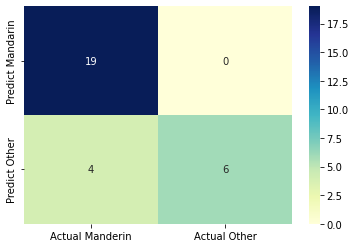

In [70]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Manderin', 'Actual Other'], 
                                 index=['Predict Mandarin', 'Predict Other'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Support Vector Manchine

In [73]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [74]:
y_pred = clf.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 1.0000


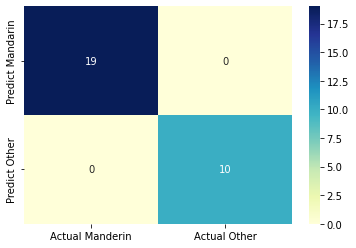

In [76]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Manderin', 'Actual Other'], 
                                 index=['Predict Mandarin', 'Predict Other'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')